## Прогноз оттока клиентов. Отчет

### Описание проекта

  Отдел маркетинга провел исследование и выяснил, что в последнее время из нашей компании все чаще начали уходить клиенты к конкурентам. Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента.
  
  Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
  
  В связи с этим <i>необходимо разработать модель прогнозирования оттока клиентов</i>.

#### План работы

1. Загрузка данных.
2. Предобработка данных - работа с пропусками, дубликатами и так далее.
3. Исследовательский анализ, который включает в себя поиск аномальных значений, анализ полезных признаков, выявление закономерностей.
4. Построение и обучение моделей с подбором гиперпараметров. RandomForest, LightGBM и полносвязную нейронную сеть.
5. Тестирование лучшей модели.

#### Цель проекта

Небходимо построить и обучить модель, которая спрогнозирует уход клиента. Используя метрику ROC-AUC, необходимо добиться точности модели не менее 0.75.

### Загрузка данных

В исходных данных было 4 таблицы:
 1. contract. Содержит всю информацию о договоре (дата подписания и расторжения, тип платежей, метод оплаты, стоимость в месяц, наличие безбумажного счета, общая сумма выплат и индентификатор пользователь).
 2. personal. Содержит некоторые данные о клиентах (идентификатор, наличие партнера, инвалидности, статуса пожилого).
 3. internet. Содержит данные об интернет-услугах, что использует пользователь (тип подключения, блокировка небезопасных сайтов, облачное хранилище, антивирус, техподдержка, стриминговое тв, каталог фильмов и идентификатор пользователя).
 4. phone. Содержит столбец указывающий на наличие или отсутствие услуги стационарной телефонной связи у пользователя.

Столбец **EndDate** таблицы contract, указывающий на дату расторжения договора, отсылает нас на **целевой признак**. Мы создали столбец *is_out*, в котором ушедшим пользователям присваивали 1, а оставшимся 0. Это наш целевой признак.

Все данные актуальны до 2020-02-01.

### Предобработка данных

Еще на загрузке данных было выявлено что в таблицах отсутствуют явные пропуски (значения None). Практически все названия столбцов необходимо было перевести в нижний регистр с нижними подчеркиваниями. Явные и неявные дубликаты отсутствовали.

Многие столбцы со значениями *Yes*/*No* можно было перевести в булевый тип, мы не стали этого делать так как в дальнейшем следовала кодировка признаков. Но изменили тип столбцов с датами, так как они нам пригодятся при создании признака.

На этапе редактирования типа данных столбцов проблемы возникли лишь с одним столбцом в таблице **contract**: столбец **total_charges**, содержащий общую сумму выплат пользователя за все время, имел не только тип данных *object*, но еще и пробелы вместо пропусков (" "). Посмотрев на все эти строки (11 строк), выяснилось что все эти договоры были подписаны *2020-02-01*. Так как данные актуальны именно на это число, эти люди не успели совершить первый платеж, из-за чего в таблицу были внесены пробелы.

###  Исследовательский анализ

С помощью столбцов с датами вы построили признак показывающий "продолжительность жизни" клиента, то есть сколько дней по сегодняшний день он пользовался услугами.

Прежде всего нужно объединить все 4 таблицы в одну для дальнейшего анализа. Объедение произошло по общему столбцу идентификатора пользователя. 
Проблема была в том, что пользователей всего должно быть 7043 (размер таблицы *contract*), но в таких таблицах как *internet* и *phone* строк было меньше. Все дело в том, что не все пользователи пользовались обеими услугами, и кто-то не попал в таблицу *internet* или в *phone*. Поэтому все образовавшиеся пропуски в их столбцах были заполнены значением 'No', так как пользователь не использовал услугу.

Из таблицы были удалены идентификаторы пользователей и даты, так как они не нужны для обучения моделей.

#### Анализ аномальных значений

Далее по колличественным столбцам (*monthly_charges - сумма помесячных платежей*, *total_charges*) были построены диаграммы размаха для оценки распределения и выбросов.

Первый и второй не имели никаких отклонений:

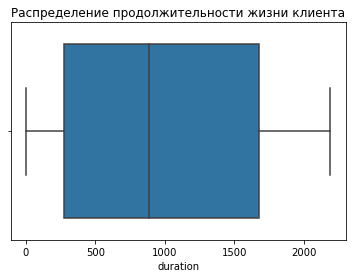

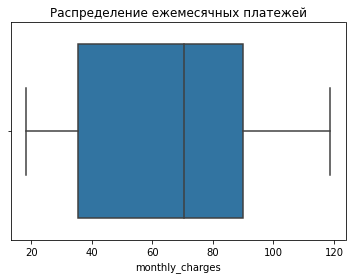

Во третьем столбце медиана умеренно была смещена влево:

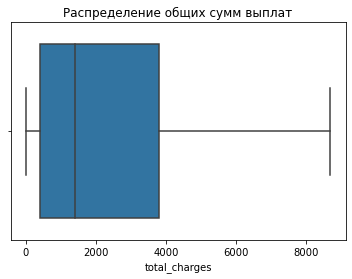

Гипотеза состояла в том, что люди с типом платежа 'Month-to-month' (помесячно) будут иметь низкие значения, а типы 'One Year'/'Two Years' (за год/за два) - высокие. Вывели диаграмму размаха по тому же столбцу, но поделили в зависимости от типа платежа:

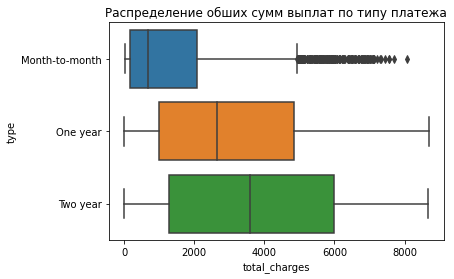

Так и оказалось. Также были выявлены выбросы по типу Month-to-month, построив гистограмму, можно сделать вывод что значения общих выплат больше 3000 считаются редкими и должны быть удалены:

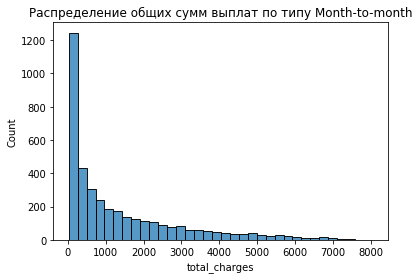

Далее данные были закодированы техникой **OrdinalEncoding**.

#### Анализ корреляций и отбор признаков

Сперва мы построили гистограммы по каждому признаку с заливкой по целевому признаку с целью выявить те признаки, которые никак не влияют на уход клиента. Самым интересным оказался график, опять таки, по общим выплатам:

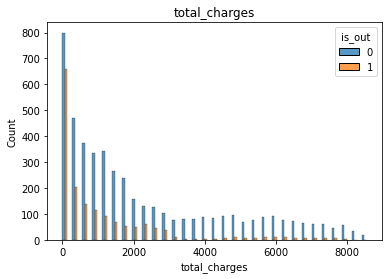

Доля ушедших тем больше чем ближе к нулю значения. Это объясняется тем, что люди не станут много и долго оплачивать неинтересные им услуги, они уходят раньше и оставляют значения *total_charges* маленькими.

Если рассмотреть именно этот отрезок - [0; 400], то можно уже без статистики и коэффициентов увидеть какие признаки повлияли на уход. С помощью библиотеки *seaborn* и *phik* мы построили тепловую карту, по которой можно оценить мультиколлинеарность признаков:

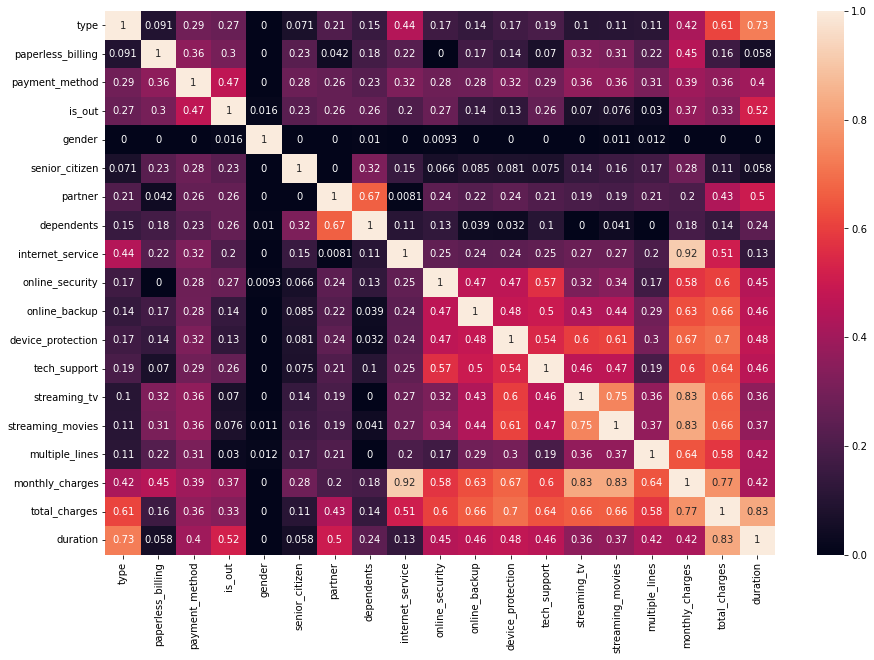

Обнаружены следующие пары взаимосвязей:

1. Наличие партнера - инвалидность
2. Ежемесячные платежи - тип подключения
3. Все интернет-услуги коррелируют между собой
4. Ежемесячные платежи - общие выплаты

Один из пары признаков не несет новой информации для модели и их можно удалить.

Таким же образом можно обнаружить признаки коррелирующие с целевым признаков *is_out*. Пол, облачное хранилище, антивирус, стриминговое тв, каталог фильмов и стационарная телефонная связь не влияют на уход клиента.

Учитывая мультиколлинеарность и корреляции с целевым признаком, для обучения подходят следующие признаки:
* type - тип платежа
* paperless_billing - безбумажное выставление счетов
* payment_method - метод оплаты
* senior_citizen - наличие статуса пожилого
* partner - наличие партнера
* internet_service - тип подключения к интернету
* total_charges - сумма общих выплат

По итогу у нас всего один количественный признак, стандартизация не потребовалась.

Разделили признаки на тренировочную, валидационную и тестовую выборки с соотношением размеров 3:1:1.

Далее мы учли дисбаланс классов, единиц в 3 раза меньше нулей: создали обучающую выборку, применив функцию **upsampling**.

### Обучение моделей

Мы использовали два варианта обучения моделей: выборка с сэмплированием и внутренний баланс классов (аргумент class_weight='balanced') у моделей. Всего будем испытывать 3 модели:
1. RandomForestClassifier.
2. LGBMClassifier.
3. Полносвязная нейронная сеть.

В качестве итоговой метрики мы используем ROC-AUC, для подбора гиперпараметров мы использовали OptunaSearchCV, архитектура нейронной сети была построена вручную, и по окончании всего процесса обучения мы имеем следующие результаты:

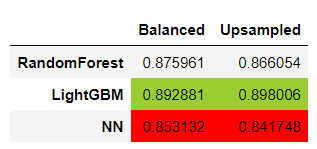

Переобучение контролировалось валидационной выборкой, все модели можно смело использовать. LightGBM показала лучшую точность в двух вариантах обучения, ее мы и будем тестировать. 

Перед этим посмотрим какие признаки она наделила как более важные:

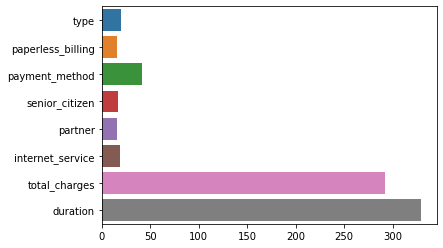

Самыми значимыми признаками оказались столбцы:
1. Продолжительность жизни клиента
2. Общая сумма выплат
3. Метод оплаты.

Финальная модель имеет следующие гиперпараметры:

*LGBMClassifier( {'n_estimators': 25, 
                    'max_depth': 14, 
                    'learning_rate': 0.8766786635906021, 
                    'reg_alpha': 0.13502253108756318})*
               
Лучший обучающий набор данных - *(x_upsampled, y_upsampled)*

### Тестирование модели

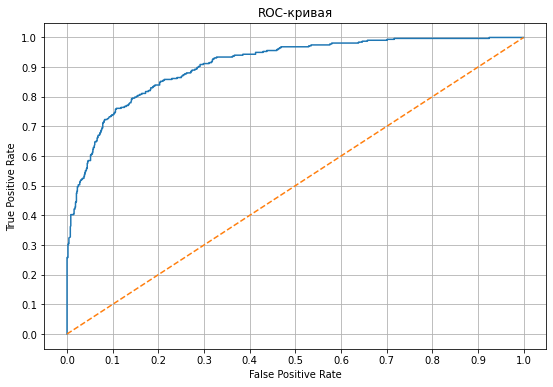

**ROC-AUC = 0.908**

Модель успешно справляется с прогнозированием ухода клиента.